### Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # For nice progress bar!
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import math
import os
from scipy.integrate import *
import pandas as pd
import csv
import matplotlib.pyplot as plt

###  Описание объекта в виде системы ОДУ


---



$\left\{\begin{array}{l}
\dot{x}_1= u_1\sin{(x_2+u_2)} \\
\dot{x}_2= x_1\cos{(x_1u_2)} \\
\end{array}\right.$

$ $

---

$ $

Начальное состояние системы:  $\mathbf{x}^0 = \left[0\;0\right]^\mathrm{T}$,

Ограничение на управление:  $u_i \in \left[-1;1\right], i={1,2}$.

$t_0 = 0$ , $t_{max}=5$, $\Delta t=0.01$.



### Константы

In [50]:
dt = 0.01 # дельта t
tmax = 5 # время интегрирования
du = 0.1 # шаг изменения управления
umin = [-1, -1] # ограничение на управление снизу
umax = [1, 1] # ограничение на управление сверху
dx = 0.5 # шаг изменения значения начального угла положения робота
state_dim = 2 # размерность вектора состояния
control_dim = 2 # размерность вектора управления

dataset_csv_name = 'dataset.csv'
weights_fname = "weights.pth"

In [51]:
def dynamic_object_model(x, u):
    return [u[0] * np.sin(x[1] + u[1]),
            x[0] * np.cos(x[0] * u[1])]

In [52]:
def Euler2(x0, u, dt, state_dim):
    res = []
    dt1 = []
    dt2 = []
    for i in range(0, state_dim):
        dt1.append(dt)
        dt2.append(dt/2)

    stepres = []
    stepres.append(np.array(x0))
    tempdotX = dynamic_object_model(x0, u)
    tempX = x0 + np.multiply(tempdotX, dt2)
    dotX = dynamic_object_model(tempX, u)
    x0 = x0 + np.multiply(dotX, dt1)
    stepres.append(np.array(dotX))
    res.append(stepres)

    return res


# Создание обучающей выборки

In [54]:
# Интервалы наблюдения
t = np.arange(0, tmax, dt)

# подготовка обучающей выборки
column_names = ['x1','x2','u1','u2','dotx1','dotx2']
train_set = []

all_x01 = np.arange(-2*math.pi, 2*math.pi, dx)
all_x02 = np.arange(-2*math.pi, 2*math.pi, dx)
all_u1 = np.arange(umin[0], umax[0]+du, du)
all_u2 = np.arange(umin[1], umax[1]+du, du)

###
print('Количество точек x[0] - %d' % (len(all_x01)))
print('Количество точек x[1] - %d' % (len(all_x02)))
print('Количество точек u[0] - %d' % (len(all_u1)))
print('Количество точек u[1] - %d' % (len(all_u2)))
###

# цикл по разным начальным значениям угла поворота робота
for x01 in all_x01:
    for x02 in all_x02:
        # Начальное состояние системы
        x0 = [x01, x02]
        # цикл по разным значениям управления
        for u1 in all_u1:
            for u2 in all_u2:
                u = [u1, u2]

                ts = Euler2(x0, u, dt, state_dim)

                for row in ts:
                    train_row = []
                    for item in row[0]:
                        train_row.append(item)

                for item in u:
                    train_row.append(item)

                for item in row[1]:
                    train_row.append(item)

                train_set.append(train_row)


dataframe = pd.DataFrame(train_set, columns=column_names)
dataframe


Количество точек x[0] - 26
Количество точек x[1] - 26
Количество точек u[0] - 21
Количество точек u[1] - 21


,x1,x2,u1,u2,dotx1,dotx2
0,-6.283185,-6.283185,-1.0,-1.0,0.858027,-6.278922
1,-6.283185,-6.283185,-1.0,-0.9,0.798871,-5.066993
2,-6.283185,-6.283185,-1.0,-0.8,0.724086,-1.923358
3,-6.283185,-6.283185,-1.0,-0.7,0.636762,1.954078
4,-6.283185,-6.283185,-1.0,-0.6,0.543486,5.087166
...,...,...,...,...,...,...
298111,6.216815,6.216815,1.0,0.6,0.486234,-5.167841
298112,6.216815,6.216815,1.0,0.7,0.583199,-2.182603
298113,6.216815,6.216815,1.0,0.8,0.675507,1.621559
298114,6.216815,6.216815,1.0,0.9,0.756302,4.818387


In [55]:
train, test = train_test_split(dataframe, test_size=0.1)

In [56]:
TS_x = dataframe.loc[:, ['x1', 'x2', 'u1', 'u2']]
TS_y = dataframe.loc[:, ['dotx1', 'dotx2']]

# число входов
arg_num = TS_x.shape[1]

# число выходов
f_num = TS_y.shape[1]

print('Число входов: %d, число выходов: %d' % (arg_num, f_num))


Число входов: 4, число выходов: 2


# Модель нейронной сети #


In [68]:
# Параметры
NUM_EPOCHS = 100 # Количество эпох
LEARNING_RATE=1e-3 # Скорость обучение (Используется в методах оптимизации на основе градиентного спуска)
HIDDEN_LAYERS = 100
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [69]:
class NNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, HIDDEN_LAYERS)
        self.fc2 = nn.Linear(HIDDEN_LAYERS, HIDDEN_LAYERS)
        self.fc3 = nn.Linear(HIDDEN_LAYERS, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.fc3(x)
        return x


In [70]:
class NNDataset(Dataset):
  def __init__(self, dataframe, device):

    TS_x = dataframe.loc[:, ['x1', 'x2', 'u1', 'u2']].values
    TS_y = dataframe.loc[:,['dotx1','dotx2']].values
 
    self.x_train=torch.tensor(TS_x,dtype=torch.float32).to(device)
    self.y_train=torch.tensor(TS_y,dtype=torch.float32).to(device)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [71]:
train_dataset = NNDataset(train, device)
test_dataset = NNDataset(test, device)
train_loader=DataLoader(train_dataset,batch_size=1000,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=False)

In [72]:
# Initialize network
model = NNModel(input_dim=arg_num, output_dim=f_num).to(device)
model

NNModel(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

In [73]:
# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [74]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    model.eval()

    with torch.no_grad():
        dist = 0
        for x, y in loader:
            scores = model(x)
            dist = dist + (scores.cpu().detach().numpy() - y.cpu().detach().numpy())**2
    model.train()
    dist = (dist / len(loader)) **0.5

    return dist.mean()

In [75]:
for x, y in test_loader:
    print(x)
    print(y)
    break

tensor([[ 3.7168,  2.2168, -0.3000,  0.8000]], device='cuda:0')
tensor([[-0.0428, -3.6641]], device='cuda:0')


In [76]:
# Train Network
epoch_losses = []
for epoch in range(NUM_EPOCHS):
    losses = []
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()
        # gradient descent or adam step
        optimizer.step()
        losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Accuracy on test set: {check_accuracy(test_loader, model)}")
        print(f":Loss on train: {np.mean(losses)}")
    epoch_losses.append(np.mean(losses))
    


100%|██████████| 269/269 [00:01<00:00, 183.12it/s]


Accuracy on test set: 1.52281653881073
:Loss on train: 3.572147563487624


100%|██████████| 269/269 [00:01<00:00, 198.99it/s]


Accuracy on test set: 1.2513872385025024
:Loss on train: 2.3408248433393175


100%|██████████| 269/269 [00:01<00:00, 201.37it/s]


Accuracy on test set: 1.0044922828674316
:Loss on train: 1.3916544927540322


100%|██████████| 269/269 [00:01<00:00, 212.44it/s]


Accuracy on test set: 0.9509651064872742
:Loss on train: 1.2188256296526543


100%|██████████| 269/269 [00:01<00:00, 208.48it/s]


Accuracy on test set: 0.911871075630188
:Loss on train: 1.1006111391858098


100%|██████████| 269/269 [00:01<00:00, 190.14it/s]


Accuracy on test set: 0.8568404912948608
:Loss on train: 0.9516536857115735


100%|██████████| 269/269 [00:01<00:00, 185.59it/s]


Accuracy on test set: 0.8215227127075195
:Loss on train: 0.8596373749931505


100%|██████████| 269/269 [00:01<00:00, 186.14it/s]


Accuracy on test set: 0.8069165349006653
:Loss on train: 0.8055624494322171


100%|██████████| 269/269 [00:01<00:00, 182.35it/s]


Accuracy on test set: 0.7977253198623657
:Loss on train: 0.7719487902400218


100%|██████████| 269/269 [00:01<00:00, 196.71it/s]


Accuracy on test set: 0.7783523201942444
:Loss on train: 0.7451843699114916


100%|██████████| 269/269 [00:01<00:00, 195.69it/s]


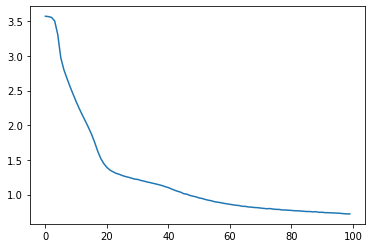

In [78]:
plt.plot(epoch_losses)

In [41]:
# save model
torch.save(model.state_dict(), weights_fname)

# Графики для обученной сети

### Постоянные значения управления

In [42]:
# load model
model = NNModel(arg_num, f_num)
model.load_state_dict(torch.load(weights_fname))
model.eval().to(device)

NNModel(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

In [83]:
# Интервалы наблюдения
t = np.arange(0,tmax,dt)

# Выбор начального значения вектора состояния
x0kd = [0, 0]

# Выбор значения управления - от -1 до 1
uk1 = 0.5
uk2 = 0.5

print('Графики при x0 = [%f, %f] и управлении = [%f, %f]' % (x0kd[0], x0kd[1], uk1, uk2))

uk = []
for i in range(0,len(t)):
  uk.append([uk1, uk2])


Графики при x0 = [0.000000, 0.000000] и управлении = [0.500000, 0.500000]


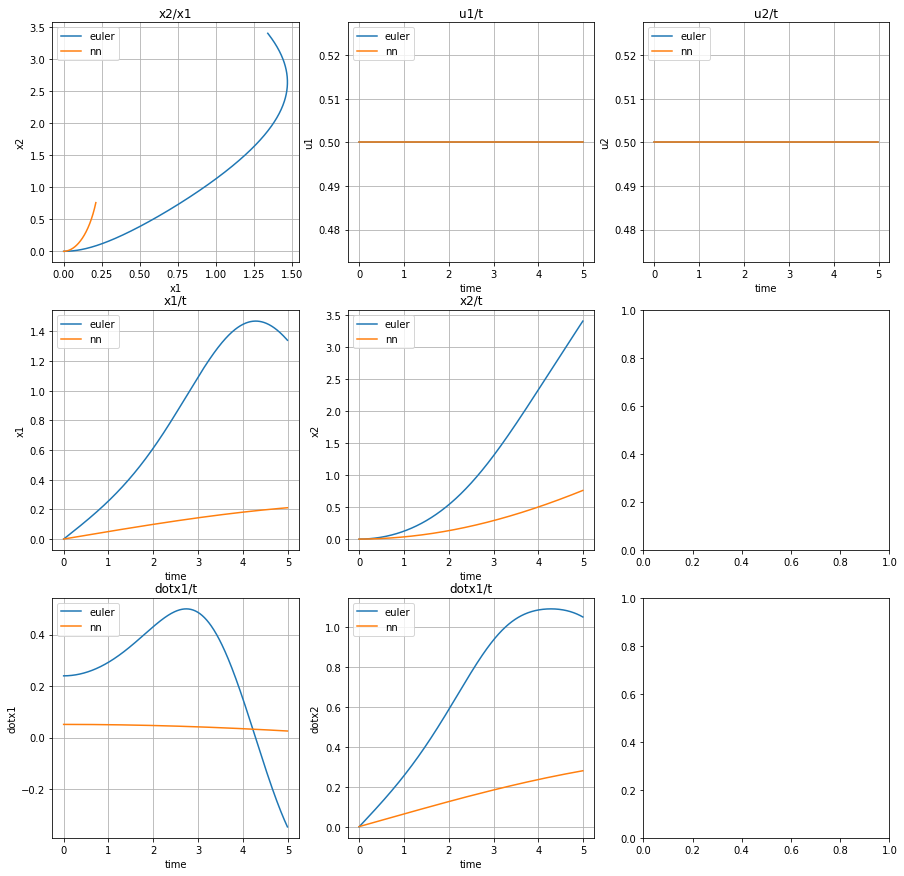

In [94]:
# x2x1Str = ('График изменения x2 от x1')
# x1Str = ('График изменения x1 от t')
# x2Str = ('График изменения x2 от t')
# u1Str = ('График изменения u1 от t')
# u2Str = ('График изменения u2 от t')
# dotx1Str = ('График изменения dotx1 от t')
# dotx2Str = ('График изменения dotx2 от t')

x2x1Str = ("x2/x1")
x1Str = ("x1/t")
x2Str = ("x2/t")
u1Str = ("u1/t")
u2Str = ("u2/t")
dotx1Str = ("dotx1/t")
dotx2Str = ("dotx2/t")

y_ref = []
neural_res = []

x0k = [x0kd[0], x0kd[1]]

x0nn = []
x0nn.append(x0k[0])  # x1
x0nn.append(x0k[1])  # x2
x0nn.append(uk[i][0])  # u1
x0nn.append(uk[i][1])  # u2
x_input = [x0nn]

x0ns = []
x0ns.append(x0k[0])  # x1
x0ns.append(x0k[1])  # x2

for i in range(0, len(t)):
    nn_res = model(torch.Tensor(x_input).to(device)).cpu().detach().numpy()
    opt_res = Euler2(x0k, uk[i], dt, state_dim)

    if (len(nn_res) == 1 and len(opt_res) == 1):
        y_row = []
        nn_row = []

        # reference state
        for item in opt_res[0][0]:
            y_row.append(item)

        # nn state
        for j in range(0, state_dim):
            nn_row.append(x0ns[j] + dt * nn_res[0][j])

        # control
        for item in uk[i]:
            y_row.append(item)
            nn_row.append(item)

        # reference derivative
        for item in opt_res[0][1]:
            y_row.append(item)

        # nn derivative
        for item in nn_res[0]:
            nn_row.append(item)

        # reference next state
        for j in range(0, state_dim):
            x0k[j] = x0k[j] + dt*y_row[4+j]

        # nn next input
        x0nn = []
        if (i < len(t)-1):
            x0nn.append(nn_row[0])  # x1
            x0nn.append(nn_row[1])  # x2
            x0nn.append(uk[i+1][0])  # u1
            x0nn.append(uk[i+1][1])  # u2
        x_input = [x0nn]

        # check nn state angle for exeeding 2*pi value
        if (nn_row[2] > 1):
            nn_row[2] = nn_row[2] - 1
        if (nn_row[2] < -1):
            nn_row[2] = nn_row[2] + 1

        # nn new current state
        for j in range(0, state_dim):
            x0ns[j] = nn_row[j]

        y_ref.append(y_row)
        neural_res.append(nn_row)

y_ref = np.asarray(y_ref)
y_ref = y_ref.T

neural_res = np.asarray(neural_res)
neural_res = neural_res.T

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

axs[0, 0].plot(y_ref[0], y_ref[1], label="euler")
axs[0, 0].plot(neural_res[0], neural_res[1], label="nn")
axs[0, 0].set_xlabel('x1')
axs[0, 0].set_ylabel('x2')
axs[0, 0].grid()
axs[0, 0].set_title(x2x1Str)
axs[0, 0].legend(loc="upper left")


axs[0, 1].plot(t.T, y_ref[2], label="euler")
axs[0, 1].plot(t.T, neural_res[2], label="nn")
axs[0, 1].set_xlabel('time')
axs[0, 1].set_ylabel('u1')
axs[0, 1].grid()
axs[0, 1].set_title(u1Str)
axs[0, 1].legend(loc="upper left")


axs[0, 2].plot(t, y_ref[3], label="euler")
axs[0, 2].plot(t, neural_res[3], label="nn")
axs[0, 2].set_xlabel('time')
axs[0, 2].set_ylabel('u2')
axs[0, 2].grid()
axs[0, 2].set_title(u2Str)
axs[0, 2].legend(loc="upper left")


axs[1, 0].plot(t, y_ref[0], label="euler")
axs[1, 0].plot(t, neural_res[0], label="nn")
axs[1, 0].set_xlabel('time')
axs[1, 0].set_ylabel('x1')
axs[1, 0].grid()
axs[1, 0].set_title(x1Str)
axs[1, 0].legend(loc="upper left")


axs[1, 1].plot(t, y_ref[1], label="euler")
axs[1, 1].plot(t, neural_res[1], label="nn")
axs[1, 1].set_xlabel('time')
axs[1, 1].set_ylabel('x2')
axs[1, 1].grid()
axs[1, 1].set_title(x2Str)
axs[1, 1].legend(loc="upper left")


# axs[1, 2].plot(t, y_ref[2], label=x3Str)
# axs[1, 2].plot(t, neural_res[2], label=x3Str)
# axs[1, 2].set_xlabel('Время')
# axs[1, 2].set_ylabel('x3')
# axs[1, 2].grid()
# axs[1, 2].set_title(x3Str)


axs[2, 0].plot(t, y_ref[4], label="euler")
axs[2, 0].plot(t, neural_res[4], label="nn")
axs[2, 0].set_xlabel('time')
axs[2, 0].set_ylabel('dotx1')
axs[2, 0].grid()
axs[2, 0].set_title(dotx1Str)
axs[2, 0].legend(loc="upper left")


axs[2, 1].plot(t, y_ref[5], label="euler")
axs[2, 1].plot(t, neural_res[5], label="nn")
axs[2, 1].set_xlabel('time')
axs[2, 1].set_ylabel('dotx2')
axs[2, 1].grid()
axs[2, 1].set_title(dotx1Str)
axs[2, 1].legend(loc="upper left")


# axs[2, 2].plot(t, y_ref[7], label=dotx3Str)
# axs[2, 2].plot(t, neural_res[7], label=dotx3Str)
# axs[2, 2].set_xlabel('Время')
# axs[2, 2].set_ylabel('dotx3')
# axs[2, 2].grid()
# axs[2, 2].set_title(dotx3Str)